# Runthrough of Use Case 9 - Data Discovery and Analysis

### Configure variables for this demo

In [20]:
import os
from dotenv import load_dotenv

platform_domain = "staging.eodatahub.org.uk"
workspace = "workflowtestuser"
load_dotenv(".env")
token = os.environ["API_TOKEN"]
workspaces_bucket = "workspaces-eodhp-staging"

## Resource Catalogue

### Searching the entire catalogue

In [21]:
!pip install pystac-client
!pip install matplotlib
!pip install pillow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/

# Create STAC client
stac_client = Client.open(rc_url)

In [23]:
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    print(child.id)

supported-datasets
user-datasets


In [24]:
# See all collections available (recursive searching)
collections = stac_client.get_collections()

for collection in collections:
    print(f"Collection {collection.id} can be found at {collection.get_self_href()}")

Collection ukcp can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/ukcp
Collection sentinel2_ard can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard
Collection sentinel1 can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel1
Collection land_cover can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/land_cover
Collection eocis-sst-cdrv3-climatology can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/eocis-sst-cdrv3-climatology
Collection eocis-sst-cdrv3 can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/c

In [25]:
# Do some collection searching using keywords
collection_search = stac_client.collection_search(
    q="climate",
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

2 collections found
ukcp
land_cover


In [26]:
# Do some collection searching using bbox
uk_bbox = [10.854492,49.823809,100.762709,60.860699]
collection_search = stac_client.collection_search(
    bbox=uk_bbox,
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

found 10 on the next page
found 1 on the next page
21 collections found
sentinel1
land_cover
eocis-sst-cdrv3-climatology
eocis-sst-cdrv3
eocis-lst-s3b-night
eocis-lst-s3b-day
eocis-lst-s3a-night
eocis-lst-s3a-day
eocis-lst-day
eocis-aerosol-slstr-monthly-s3b
eocis-aerosol-slstr-monthly-s3a
eocis-aerosol-slstr-daily-s3b
eocis-aerosol-slstr-daily-s3a
cordex
cop-dem-glo-30
cmip6
cci
airbus_spot_data
airbus_sar_data
airbus_pneo_data
airbus_phr_data


In [27]:
# Do some collection searching using datetime, looking into the future
time_to_search = "2026-01-06T00:00:00Z/.."
collection_search = stac_client.collection_search(
    datetime=time_to_search,
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

3 collections found
ukcp
cordex
cmip6


In [ ]:
# We can then get all the items in the cmip6 collection
from pystac_client import CollectionClient

collection_search = stac_client.collection_search(
    datetime=time_to_search,
)
cclient = CollectionClient.from_dict(list(collection_search.collections_as_dicts())[2], root=stac_client)
items = list(cclient.get_items())
len(items)
print(items[:10])

In [10]:
# Do some item searching
# Geometry for the UK
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-4.41191386337143, 50.5437323318846],
            [-2.86223024423239, 50.5522106222613],
            [-2.86502949737798, 49.564676297854],
            [-4.3832372671439, 49.5564878434316],
            [-4.41191386337143, 50.5437323318846]
        ]
    ],
}
search = stac_client.search(
    max_items=10,
    collections=['cmip6'],
    intersects=geom,
)
for item in search.items():
    print(item.id)

CMIP6.ScenarioMIP.THU.CIESM.ssp585.r1i1p1f1.Amon.rsus.gr.v20200806
CMIP6.ScenarioMIP.THU.CIESM.ssp585.r1i1p1f1.Amon.rlus.gr.v20200806
CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.r1i1p1f1.Amon.clivi.gr.v20210419
CMIP6.ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.r1i1p1f1.day.uas.gn.v20210318
CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.r1i1p1f1.day.pr.gn.v20210317
CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317
CMIP6.ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r1i1p1f1.day.rsds.gn.v20210318
CMIP6.ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r1i1p1f1.day.hurs.gn.v20210318
CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.r1i1p1f1.day.tas.gn.v20210317
CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.r1i1p1f1.day.psl.gn.v20210317


In [11]:
# We can then see the assets for one of these items
assets = item.get_assets()

for asset in assets:
    print(f"Asset {asset} is available at {assets[asset].href}")

Asset reference_file is available at https://dap.ceda.ac.uk/badc/cmip6/metadata/kerchunk/pipeline1/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/kr1.0/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_r1i1p1f1_day_psl_gn_v20210317_kr1.0.json
Asset data0001 is available at https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/psl/gn/v20210317/psl_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_22010101-22501231.nc
Asset data0002 is available at https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/psl/gn/v20210317/psl_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_22510101-23001231.nc


In [12]:
# Demonstrate that we support more complex searching via filters extension
filter = {
        "op": "and",
        "args": [
          {
            "op": "between",
            "args": [
              {
                "property": "properties.datetime"
              },
              "2020-01-12T00:00:00.000Z",
              "2025-02-12T23:59:59.999Z"
            ]
          },
          {
            "op": "and",
            "args": [
              {
                "op": "=",
                "args": [
                  {
                    "property": "collection"
                  },
                  "sentinel2_ard"
                ]
              },
              {
                "op": "<=",
                "args": [
                  {
                    "property": "properties.eo:cloud_cover"
                  },
                  5
                ]
              }
            ]
          }
        ]
      }
    
search = stac_client.search(
    max_items=10,
    filter=filter,
    fields={"include": ["properties.datetime", "properties.eo:cloud_cover"]},
)

for item in search.items():
    print(item.id)
    print(f"Datetime is {item.properties['datetime']}")
    print(f"Cloud cover is {item.properties['eo:cloud_cover']}")

# To then use such an item in a workflow, you can retrieve the href
for link in item.links:
    if link.rel == "self":
        print(f"Self href for item {item.id} is {link.href}")

neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn554lonw0021_T30UWG_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.0
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn546lonw0022_T30UWF_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.303176949448
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn537lonw0022_T30UWE_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 2.996021415101
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn536lonw0007_T30UXE_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.321000925677
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn528lonw0022_T30UWD_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 3.548329970558
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb


### Our deployment also supports nested catalogs, which we can return by listing the children for a specific catalog

In [13]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/supported-datasets"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets

# Create STAC client
stac_client = Client.open(rc_url)

In [15]:
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    print(child.id)
    # We will also print the first three collections in each
    children = child.get_children()
    for i in range(3):
        next_child = next(children, None)
        if not next_child:
            break
        print("   " + next_child.id)

airbus
   airbus_phr_data
   airbus_pneo_data
   airbus_sar_data
ceda-stac-catalogue
   cci
   cmip6
   cordex
earth-search-aws
   cop-dem-glo-30
planet
   PSScene
   REOrthoTile
   REScene


In [16]:
# Then we can see the child collections for one of these catalogs
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    if child.id == "ceda-stac-catalogue":
        ceda_catalog = child
        break

collections = ceda_catalog.get_children()

for collection in collections:
    print(collection.id)

cci
cmip6
cordex
eocis-aerosol-slstr-daily-s3a
eocis-aerosol-slstr-daily-s3b
eocis-aerosol-slstr-monthly-s3a
eocis-aerosol-slstr-monthly-s3b
eocis-lst-day
eocis-lst-s3a-day
eocis-lst-s3a-night
eocis-lst-s3b-day
eocis-lst-s3b-night
eocis-sst-cdrv3
eocis-sst-cdrv3-climatology
land_cover
sentinel1
sentinel2_ard
ukcp


### We can also access private catalogs by providing credentials to the client

In [17]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/user-datasets"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets

# Create STAC client without authentication
stac_client = Client.open(rc_url)

In [18]:
# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see that no child catalogs are provided, as auth is required for user catalogs

for child in children:
    print(child.id)


sparkgeouser


In [19]:
# And now with authentication
# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs

for child in children:
    print(child.id)

sparkgeouser
tjellicoe-tpzuk
workflowtestuser


In [20]:
# Navigate to workflow output sub catalog
# And now with authentication
# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})
# See all the available children in this catalogue
children = stac_client.get_children()
# We can then see the child catalogs
for child in children:
    if child.id == workspace:
        priv_cat = child
        break
priv_cat_children = priv_cat.get_children()
for cat in priv_cat_children:
    if cat.id == "processing-results":
        proc_res_cat = cat
for workflow_cat in proc_res_cat.get_children():
    if workflow_cat.id == "convert-url-test":
        for job in workflow_cat.get_children():
            print(job.id)

cat_3f4db7ca-ed08-11ef-b95b-ca3e8cd28499
cat_f520c3fc-e953-11ef-a139-ca3e8cd28499


In [21]:
# Print output collection from workflow
print(job.id)
collections = job.get_collections()

collection = next(collections)
items = collection.get_items()

for item in items:
    print(item.id)

cat_f520c3fc-e953-11ef-a139-ca3e8cd28499
EO-Data-Hub-logo_colour_425px-resize-1739373255.101168063


### We also include a proxy for searching the Planet API

In [22]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

In [23]:
# Now search for some items
collections = stac_client.get_children()

for collection in collections:
    print(collection.id)

PSScene
REOrthoTile
REScene
SkySatCollect
SkySatScene
SkySatVideo
TanagerMethane
TanagerScene


In [24]:
# The proxy also works when searching Planet items
search = stac_client.search(bbox=[10.854492,49.823809,100.762709,60.860699])
for i in range(5):
    print(next(search.items()).id)

20250220_093827_99_24b3
20250220_093623_76_24b3
20250220_082828_36_24d9
20250220_090806_07_24db
20250220_085450_54_24db


# Data Adaptors

## Airbus Sar Adaptor

First we will follow the path of a user discovering data they may wish to order

In [25]:
## The user will search the resource catalogue for Airbus data they wish to order
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

# Search for airbus data that meets certain criteria
search = stac_client.search(collections=["airbus_sar_data"], bbox=[10.854492,49.823809,100.762709,60.860699], max_items=10)

# View all the items returned
for item in search.items():
    print(item.id)

chosen_item = item

TSX-1_WS_S_wide_001R_97985_D33003943_29000
TSX-1_ST_S_spot_060R_97984_D32148211_435
TSX-1_SM_S_strip_014R_98015_D32043560_7992
TSX-1_SM_S_strip_006R_98008_A14244245_8000
TSX-1_SL_S_spot_067R_97983_D32248267_1422
TDX-1_SM_D_stripFar_007R_81247_A15134647_13718
TSX-1_WS_S_wide_004R_97909_D33004053_29000
TSX-1_SM_S_strip_014R_97952_D31979581_8000
TSX-1_SM_S_strip_014R_97901_A14191034_8000
TSX-1_SM_S_strip_013R_97955_D32195536_8000


In [26]:
# with the user's chosen item then can extract the link for this item in preparation to order its associated data
item_links = chosen_item.links

for link in item_links:
    if link.rel == "self":
        item_href = link.href
        print(item_href)

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/airbus/collections/airbus_sar_data/items/TSX-1_SM_S_strip_013R_97955_D32195536_8000


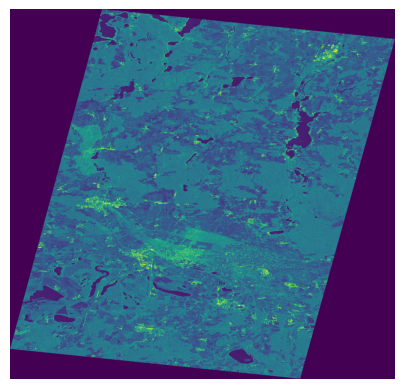

In [27]:
# A user may also wish to view any thumbnail images to confirm this is the data they wish to order
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Find the thumbnail asset
thumbnail_href = chosen_item.assets["thumbnail"].href

# URL of the TIFF image
url = thumbnail_href

# Fetch the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


### Now we are happy with the data we are ordering we can construct an order call with the adaptors API

In [ ]:
import requests

url = f"https://{platform_domain}/api/catalogue/manage/catalogs/user-datasets/{workspace}/commercial-data"
headers = {
    "accept": "application/json", 
    "Content-Type": "application/json", 
    "Authorization": f"Bearer {token}"
}
data =  {
    "url": item_href,  
    "product_bundle": "general_use"
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 200
Response  {'message': 'Item ordered successfully'}


## Airbus Optical Adaptor

### First find an item we wish to order

In [75]:
## The user will search the resource catalogue for Airbus data they wish to order
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

# Search for airbus data that meets certain criteria
search = stac_client.search(collections=["airbus_spot_data"], ids="DS_SPOT6_202502191321230_FR1_FR1_SV1_SV1_W052S19_01627", max_items=10)

# View all the items returned
for item in search.items():
    print(item.id)

chosen_item = item

DS_SPOT6_202502191321230_FR1_FR1_SV1_SV1_W052S19_01627


In [76]:
# with the user's chosen item then can extract the link for this item in preparation to order its associated data
item_links = chosen_item.links

for link in item_links:
    if link.rel == "self":
        item_href = link.href
        print(item_href)

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/airbus/collections/airbus_spot_data/items/DS_SPOT6_202502191321230_FR1_FR1_SV1_SV1_W052S19_01627


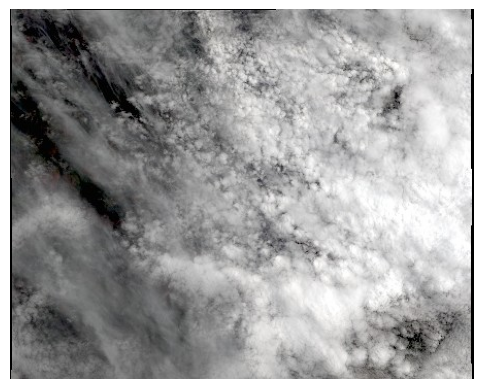

In [78]:
# A user may also wish to view any thumbnail images to confirm this is the data they wish to order
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Find the thumbnail asset
thumbnail_href = chosen_item.assets["quicklook"].href

# URL of the TIFF image
url = thumbnail_href

# Fetch the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


In [80]:
import requests

url = f"https://{platform_domain}/api/catalogue/manage/catalogs/user-datasets/{workspace}/commercial-data"
headers = {
    "accept": "application/json", 
    "Content-Type": "application/json", 
    "Authorization": f"Bearer {token}"
}
data =  {
    "url": item_href,  
    "product_bundle": "general_use",
    "coordinates":[
        [
            [-52.55,-19],
            [-52.5,-19],
            [-52.5,-19.03],
            [-52.55,-19.03],
            [-52.55,-19]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 200
Response  {'message': 'Item ordered successfully'}


## Planet Adaptor

First we need to identify the data we wish to order

In [41]:
## The user will search the resource catalogue for Airbus data they wish to order
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [20.41191386337143, 50.5437323318846],
            [22.86223024423239, 50.5522106222613],
            [22.86502949737798, 49.564676297854],
            [20.3832372671439, 49.5564878434316],
            [20.41191386337143, 50.5437323318846]
        ]
    ],
}

# Search for airbus data that meets certain criteria
# search = stac_client.search(collections=["PSScene"], datetime="2025-02-15T10:09:59.509619Z/2025-02-18T10:10:00.509619Z", bbox=[9.0, 56.9, 9.9, 57.11], max_items=10)

search = stac_client.search(collections=["PSScene"], intersects=geom, max_items=10)


# View all the items returned
for item in search.items():
    print(item.id)

chosen_item = item
coordinates = chosen_item.geometry["coordinates"]

20250220_094635_36_24d3
20250220_092021_76_24af
20250220_092014_01_24af
20250220_092017_88_24af
20250220_092012_07_24af
20250220_092019_82_24af
20250220_094944_85_2512
20250220_094637_55_24d3
20250220_094639_73_24d3
20250220_092015_95_24af


In [42]:
# with the user's chosen item then can extract the link for this item in preparation to order its associated data
item_links = chosen_item.links

for link in item_links:
    if link.rel == "self":
        item_href = link.href
        print(item_href)

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet/collections/PSScene/items/20250220_092015_95_24af


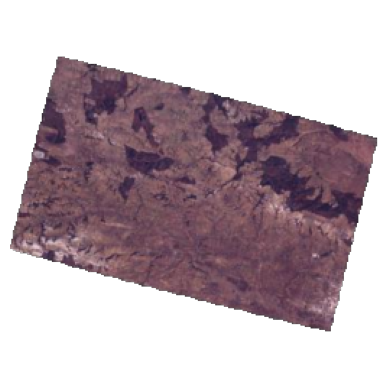

In [43]:
# A user may also wish to view any thumbnail images to confirm this is the data they wish to order
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Find the thumbnail asset
thumbnail_href = chosen_item.assets["thumbnail"].href

# URL of the TIFF image
url = thumbnail_href

# Fetch the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [44]:
import requests

url = f'https://{platform_domain}/api/catalogue/manage/catalogs/user-datasets/{workspace}/commercial-data'
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "url": item_href,  
    "product_bundle": "analytic_udm2", 
    "coordinates": coordinates
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

print(f"https://{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/{workspace}/catalogs/commercial-data/catalogs/planet/catalogs")

Status Code 200
Response  {'message': 'Item ordered successfully'}
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets/catalogs/workflowtestuser/catalogs/commercial-data/catalogs/planet/catalogs


## Checking adaptor Outputs

In [45]:
# Now that we have submitted two data requests, one for Airbus and another for Planet, 
# we can view them in the resource catalogue, once delivered

# We first need to create a pystac client instance with authentication
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/{workspace}"

# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs

for child in children:
    print(child.id)
    if child.id == "commercial-data":
        commercial_cat = child

commercial-data
processing-results
saved-data


In [46]:
# adaptor outputs are placed in the commercial-data sub-catalog
children = commercial_cat.get_children()

for c in children:
    print(c.id)
    if c.id == "planet":
        planet_cat = c
    if c.id == "airbus":
        airbus_cat = c

planet


In [47]:
## Now we can view all the outputs for the planet adaptor
outputs = planet_cat.get_children()
catalogs = {}
for o in outputs:
    print(o.id)
    catalogs[o.id] = o

cat_31e1488e-eed6-11ef-9ce3-ca3e8cd28499
cat_3af55324-ef9f-11ef-a5ed-ca3e8cd28499
cat_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499
cat_57d48c5c-efa0-11ef-925e-ca3e8cd28499
cat_af78d358-ef9d-11ef-a651-ca3e8cd28499


In [50]:
for col in catalogs["cat_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499"].get_collections():
    items = col.get_items()
    for i in items:
        print(f"Found item {i.id} in collection {col.id}")
        assets = i.assets
        for asset_name, asset in assets.items():
            if asset_name.endswith('.tif'):
                url = asset.href
                print(url)
                # response = requests.get(url, headers={"Authorization": f"Bearer {token}"})
                # print(asset_name)
                # x = response.content
                # print(x)
                # image = Image.open(BytesIO(response.content))
                # # Display the image
                # plt.imshow(image)
                # plt.axis('off')  # Hide the axis
                # plt.show() (edited) 

Found item 20250220_081249_84_24e5 in collection col_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499
https://workflowtestuser.staging.eodatahub-workspaces.org.uk/files/workspaces-eodhp-staging/commercial-data/planet/cat_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499/col_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499/20250220_081249_84_24e5_3B_AnalyticMS_clip.tif
https://workflowtestuser.staging.eodatahub-workspaces.org.uk/files/workspaces-eodhp-staging/commercial-data/planet/cat_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499/col_432fcf24-ef9f-11ef-8fb6-ca3e8cd28499/20250220_081249_84_24e5_3B_udm2_clip.tif


In [51]:
## And then any collections and items
collections = o.get_collections()

for col in collections:
    items = col.get_items()
    for i in items:
        print(f"Found item {i.id} in collection {col.id}")
        # We can also print the order status
        print(f"Order status is {i.properties['order.status']}")

Found item 20250220_112044_33_2521 in collection col_af78d358-ef9d-11ef-a651-ca3e8cd28499
Order status is failed


## Running Workflows with pyeodh

In [1]:
!pip install pyeodh


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import os

import dotenv
import json

import pyeodh

dotenv.load_dotenv()

client = pyeodh.Client(
    username=workspace,
    token=token,
    base_url=f"https://{platform_domain}",
)
ades = client.get_ades()

In [6]:
# Define a CWL application package
workflow_id = "snuggs"
cwl_yaml = f"""$graph:
- class: Workflow
  doc: Applies s expressions to EO acquisitions
  id: {workflow_id}
  requirements:
  - class: ScatterFeatureRequirement
  inputs:
    input_reference:
      doc: Input product reference
      label: Input product reference
      type: string[]
    s_expression:
      doc: s expression
      label: s expression
      type: string[]
  label: s expressions
  outputs:
  - id: wf_outputs
    outputSource:
    - step_1/results
    type:
      Directory[]

  steps:
    step_1:
      in:
        input_reference: input_reference
        s_expression: s_expression
      out:
      - results
      run: '#clt'
      scatter: [input_reference, s_expression]
      scatterMethod: flat_crossproduct


- baseCommand: s-expression
  class: CommandLineTool

  id: clt

  arguments:
  - --input_reference
  - valueFrom: $( inputs.input_reference )
  - --s-expression
  - valueFrom: ${{ return inputs.s_expression.split(":")[1]; }}
  - --cbn
  - valueFrom: ${{ return inputs.s_expression.split(":")[0]; }}
  
  inputs:
    input_reference:
      type: string
    s_expression:
      type: string

  outputs:
    results:
      outputBinding:
        glob: .
      type: Directory
  requirements:
    EnvVarRequirement:
      envDef:
        PATH: /srv/conda/envs/env_app_snuggs/bin:/srv/conda/bin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
    ResourceRequirement:
      ramMin: 10240
      coresMin: 3
    InlineJavascriptRequirement: {{}}
    DockerRequirement:
      dockerPull: eoepca/snuggs:0.3.0

cwlVersion: v1.0

$namespaces:
  s: https://schema.org/
s:softwareVersion: 0.3.0
schemas:
- http://schema.org/version/9.0/schemaorg-current-http.rdf
"""

In [35]:
# Now deploy an application package
try:
    ades.get_process(workflow_id).delete()
except Exception:
    print("Process not found, undeploy not required.")

process = ades.deploy_process(cwl_yaml=cwl_yaml)

In [36]:
# Now execute the workflow
job = ades.get_process(workflow_id).execute(
    {
        "input_reference": ["https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A","https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A"],
        "s_expression": ["ndvi:(/ (- B05 B03) (+ B05 B03))"]
    }
)
# Print the job href
print(job.self_href)

https://staging.eodatahub.org.uk/ades/workflowtestuser/ogc-api/jobs/098c5240-efb5-11ef-adab-ca3e8cd28499


In [37]:
# Monitor the job for completion
job.refresh()
print(f"Job status is {job.status}")
print(f"Job ID is {job.id}")

job_id = job.id

catalog_href = f"https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets/catalogs/{workspace}/catalogs/processing-results/catalogs/cat_{job_id}"

Job status is running
Job ID is 098c5240-efb5-11ef-adab-ca3e8cd28499


## We can now view the job outputs in the workspace catalogue

In [33]:
# Now that we have submitted two data requests, one for Airbus and another for Planet, 
# we can view them in the resource catalogue, once delivered

# We first need to create a pystac client instance with authentication
rc_url = f"https://{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/{workspace}/catalogs/processing-results"

# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs, which represent workflow output catalogs
for child in children:
    print(child.id)
    if child.id == workflow_id:
        workflow_cat = child

convert-url
convert-url-test
test-convert-url--08-27-57
test-convert-url--15-07-20


In [34]:
## View all job runs for the workflow
# Print all job runs for this workflow
children = workflow_cat.get_children()

for child in children:
    print(child.id)

NameError: name 'workflow_cat' is not defined

## EO Packages

Users can install EO data packages to view their data

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib numpy pillow folium

import os

import shapely 
import geopandas as gpd
import folium

import urllib.request
from io import BytesIO 
from PIL import Image

rut_pnt = shapely.Point(-0.683261054299237, 52.672193937442586) # a site near Rutland
thet_pnt = shapely.Point(0.6715892933273722, 52.414471075812315) # a site near Thetford

# Optional cell
# If you want to see these points on a map run this cell

# Create a map (m) centered between the two points
center_lat = (rut_pnt.y + thet_pnt.y) / 2
center_lon = (rut_pnt.x + thet_pnt.x) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add markers for each point
folium.Marker([rut_pnt.y, rut_pnt.x], popup="Rutland Site", icon=folium.Icon(color="blue")).add_to(m)
folium.Marker([thet_pnt.y, thet_pnt.x], popup="Thetford Site", icon=folium.Icon(color="green")).add_to(m)

# Step 4: Display the map
m

## PyEODH

A user can use Oxidian's PyEODH client to work with the UK EO DataHub's API.

In [ ]:
import pyeodh

# Connect to the Hub
client = pyeodh.Client().get_catalog_service()

# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase
for collect in client.get_collections():
    print(f"{collect.id}: {collect.description}")